## Data Preprocessing & Modeling

### Imports

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Models
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

# Training
from sklearn.feature_extraction.text import CountVectorizer

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

2023-12-08 01:54:32.192817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Fake News Data

In [2]:
# Read in the data
fake_news = pd.read_csv('source_folder/fake_news_cleaned.csv')
fake_news = fake_news[fake_news['text'].apply(lambda x: len(x) > 0)]

In [3]:
# Prepare text samples and their labels
texts = fake_news['text']
labels = fake_news['label']

### Text Vectorization
Convert a collection of text documents into numerical features

In [4]:
# Data vectorizer
vectorizer = CountVectorizer(analyzer="word", binary=True, min_df=2, stop_words='english')
array = vectorizer.fit_transform(texts).toarray()
get_feat = pd.DataFrame(array, columns=vectorizer.get_feature_names_out())

### Evaluation Function
Evaluate the performance of the machine learning model by computing training accuracy, testing accuracy, and generating a confusion matrix for the testing set.

In [5]:
def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    # training
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train, y_predict_train)
    
    # testing
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test, y_predict_test)
    
    return train_acc, test_acc, confusion_matrix(y_test, y_predict_test)

Create training and test data for traditional ML model

In [6]:
test_split = 0.2
get_feat_train, get_feat_test, y_train, y_test = train_test_split(get_feat, labels, test_size=test_split)

### Traditional Naive Bayes Model Function
This function encapsulates the process of training a Multinomial Naive Bayes classifier using the provided training features and labels.

In [7]:
def traditional_ml_model(get_feat_train, y_train, get_feat_test, y_test):
    model_nb = MultinomialNB()
    model_nb.fit(get_feat_train, y_train)
    
    return model_nb

In [8]:
# Train traditional ML model (Naive Bayes)
model_nb = traditional_ml_model(get_feat_train, y_train, get_feat_test, y_test)

Traditional ML Model (Naive Bayes)
Training Accuracy: 95.31%
Testing Accuracy: 93.82%


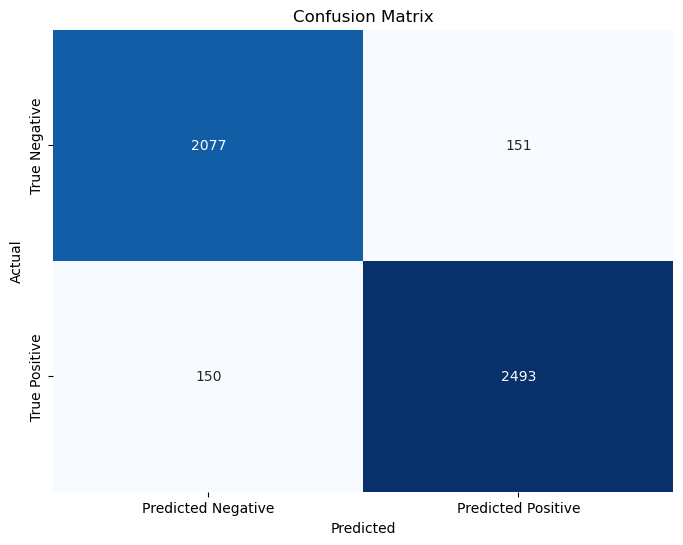

In [9]:
# Evaluate traditional ML model
train_1_nb, test_1_nb, confusion_mat_nb = evaluate_model(model_nb.predict, get_feat_train, y_train, get_feat_test, y_test)

print("Traditional ML Model (Naive Bayes)")
print("Training Accuracy: {:.2f}%".format(train_1_nb * 100))
print("Testing Accuracy: {:.2f}%".format(test_1_nb * 100))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted Negative', 'Predicted Positive'],
           yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Text Classification Tasks
Prepare text data for a neural network model by tokenizing the text, converting it into sequences of integers, padding the sequences to a consistent length, and splitting the data into training and validation sets.

In [10]:
# Prepare data for neural network model
max_words = 20000
max_seq = 7218
embedd = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, padding='pre', truncating='pre')

x_train, x_val, y_train, y_val = train_test_split(data, labels.apply(lambda x: 0 if x == 0 else 1), test_size=test_split)

### Neural Network Model Function
Defines a neural network model using the Keras Sequential API for binary classification tasks using the provided training features and labels.

In [11]:
def neural_network_model(x_train, y_train, x_val, y_val):
    model_nn = Sequential([
        layers.Embedding(max_words, embedd, input_length=max_seq, trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model_nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    metrics = model_nn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))
    
    return model_nn, metrics

In [12]:
# Train neural network model
model_nn, metrics = neural_network_model(x_train, y_train, x_val, y_val)

2023-12-08 01:57:32.544766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
153/153 [==============================] - 2465s 16s/step - loss: 0.0959 - accuracy: 0.9621 - val_loss: 0.0352 - val_accuracy: 0.9854
Epoch 2/5
153/153 [==============================] - 4332s 28s/step - loss: 0.0179 - accuracy: 0.9936 - val_loss: 0.0453 - val_accuracy: 0.9852
Epoch 3/5
153/153 [==============================] - 4412s 29s/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0336 - val_accuracy: 0.9879
Epoch 4/5
153/153 [==============================] - 4845s 31s/step - loss: 6.6146e-04 - accuracy: 0.9997 - val_loss: 0.0389 - val_accuracy: 0.9885
Epoch 5/5
153/153 [==============================] - 4343s 28s/step - loss: 1.5569e-04 - accuracy: 0.9999 - val_loss: 0.0597 - val_accuracy: 0.9877


### Save the Model

In [13]:
# Save the trained neural network model
model_nn.save('deployment_nn.h5')

153/153 [==============================] - 113s 742ms/step

Neural Network Model
Training Accuracy: 99.99%
Testing Accuracy: 98.77%


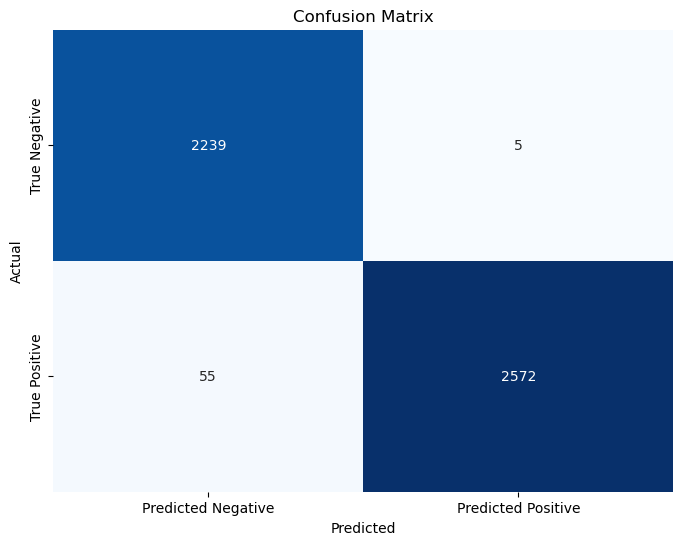

In [14]:
# Evaluate neural network model
train_1_nn, test_1_nn, confusion_mat_nn = evaluate_model(lambda x: np.rint(model_nn.predict(x)),
                                                             x_train, y_train, x_val, y_val)

print("\nNeural Network Model")
print("Training Accuracy: {:.2f}%".format(train_1_nn * 100))
print("Testing Accuracy: {:.2f}%".format(test_1_nn * 100))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_nn, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted Negative', 'Predicted Positive'],
           yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

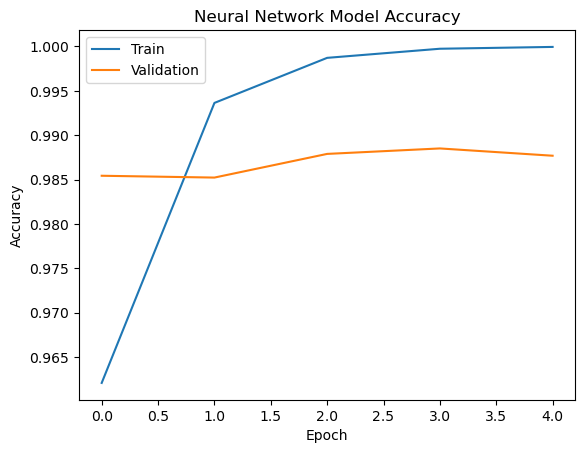

In [17]:
# Plot training & validation accuracy values for the neural network model
plt.plot(metrics.history['accuracy'])
plt.plot(metrics.history['val_accuracy'])
plt.title('Neural Network Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()